In [1]:
import os, math
from collections import defaultdict
from heapq import heapify, heappush, heappop
import itertools
import sqlite3

import logging
import logging.handlers

from PIL import Image, ImageDraw
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt
import scipy
import numpy as np
import cupy as cp
import pandas as pd

from utils import *
from hdc import *

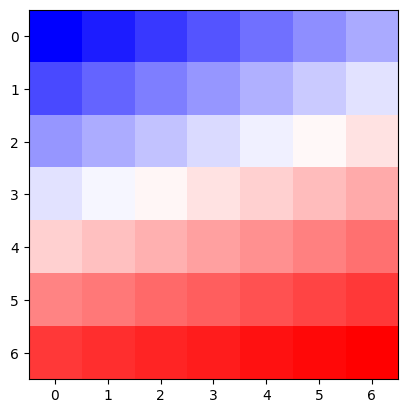

array([[-4. , -3.5, -3. , -2.5, -2. , -1.5, -1. ],
       [-2.7, -2.2, -1.8, -1.3, -0.9, -0.4, -0. ],
       [-1.3, -0.9, -0.6, -0.2,  0.2,  0.6,  1. ],
       [ 0. ,  0.3,  0.7,  1. ,  1.3,  1.7,  2. ],
       [ 1.3,  1.6,  1.9,  2.2,  2.4,  2.7,  3. ],
       [ 2.7,  2.9,  3.1,  3.3,  3.6,  3.8,  4. ],
       [ 4. ,  4.2,  4.3,  4.5,  4.7,  4.8,  5. ]])

In [37]:
a1 = np.array([-4, -1, 4, 5]).reshape(2, 2)

a2 = np.insert(a1, -1, [[0]] * 5, axis=1)
a2 = np.insert(a2, -1, [[0]] * 5, axis=0)
a2 = a2.astype(float)

interp = RegularGridInterpolator(([0, a2.shape[1] - 1], [0, a2.shape[0] - 1]), a1)

for i in range(a2.shape[0]):
    for j in range(a2.shape[1]):
        a2[i,j] = interp((i, j))

plt.imshow(a2, cmap='bwr', interpolation='nearest')
plt.show()
np.round(a2, decimals=1)

In [38]:
interp([(0, 1), (0, 2)])

array([-3.5, -3. ])

In [3]:
LOG = Logging()
LOG('hello28')

In [11]:
class LogPrefix(object):
    def __init__(self):
        self.stanzas = dict()
        self.stanzas_order = []

    def push(self, stanza_name, stanza_value):
        if stanza_name in self.stanzas:
            self.stanzas[stanza_name] = stanza_value
            return

        self.stanzas[stanza_name] = stanza_value
        self.stanzas_order.append(stanza_name)

    def pop(self, stanza_name):
        if stanza_name in self.stanzas:
            del self.stanzas[stanza_name]

        try:
            self.stanzas_order.remove(stanza_name)
        except ValueError:
            pass

    def __call__(self):
        return '[' + ','.join(map(lambda s: f'{s}={self.stanzas[s]}', self.stanzas_order)) + ']'

In [13]:
lp = LogPrefix()
lp.push('HOST', 123)
lp.push('IMAGE_ID', 345)
lp()

'[HOST=123,IMAGE_ID=345]'

In [17]:
lp.pop('?')
lp()

'[]'

In [15]:
lp.pop('HOST')
lp()

'[IMAGE_ID=345]'

In [16]:
lp.pop('IMAGE_ID')
lp()

'[]'

In [3]:
RNG = np.random.default_rng()

In [4]:
x = RNG.integers(10, size=16).reshape(4,4)
x

array([[7, 5, 3, 8],
       [0, 4, 7, 0],
       [0, 3, 2, 6],
       [0, 0, 5, 0]])

In [5]:
xa1 = np.max(x, axis=1)
xa1

array([8, 7, 6, 5])

In [6]:
xa2 = np.sum(x, axis=1)
xa2

array([23, 11, 11,  5])

In [7]:
np.argsort(-xa1)

array([0, 1, 2, 3])

In [8]:
np.argsort(-xa2)

array([0, 1, 2, 3])

In [9]:
l = [10, 20, 10, 1, 2]
np.unique_counts(l)

UniqueCountsResult(values=array([ 1,  2, 10, 20]), counts=array([1, 1, 2, 1]))

In [10]:
v = 723
f'{v:5}'

'  723'

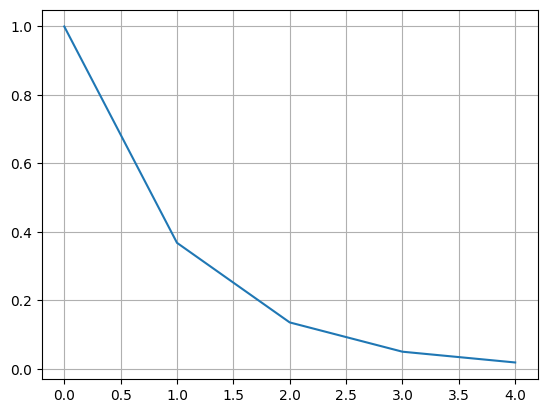

,x,y
0,0.0,1.000000
1,1.0,0.367879
2,2.0,0.135335
3,3.0,0.049787
4,4.0,0.018316


In [11]:
l = 1
xs = list(range(5))
ys = []
df = pd.DataFrame(columns=['x', 'y'])

for x in xs:
    y = l * np.exp(-l * x)
    ys.append(y)
    df.loc[len(df)] = [x, y]

plt.plot(xs, ys)
plt.grid()
plt.show()

df

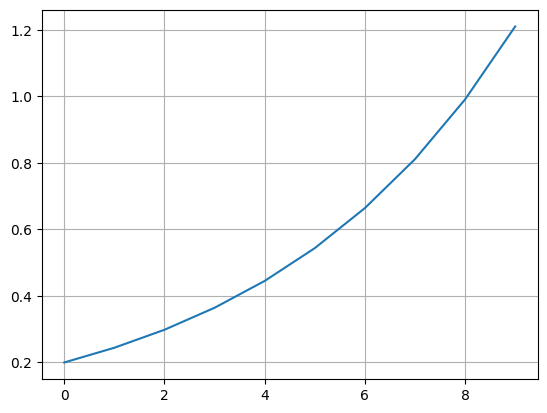

,x,y
0,0.0,0.200000
1,1.0,0.244281
2,2.0,0.298365
3,3.0,0.364424
4,4.0,0.445108
5,5.0,0.543656
6,6.0,0.664023
7,7.0,0.811040
8,8.0,0.990606
9,9.0,1.209929


In [12]:
l = 0.2
xs = list(range(10))
ys = []
df = pd.DataFrame(columns=['x', 'y'])

for x in xs:
    y = l * np.exp(l * x)
    ys.append(y)
    df.loc[len(df)] = [x, y]

plt.plot(xs, ys)
plt.grid()
plt.show()

df

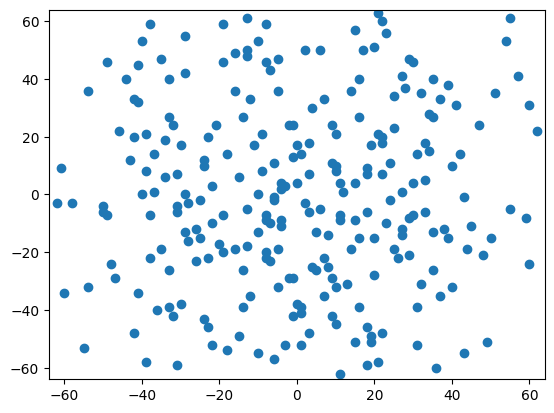

(256, 256, np.int64(-62), np.int64(62), np.int64(-62), np.int64(63))

In [13]:
mean = [0, 0]
# cov = [[1, 0], [0, 100]]  # diagonal covariance
cov = [[64, 0], [0, 64]]  # spherical covariance
xs, ys = np.random.multivariate_normal(mean, cov, 10000).T * 4
xs = xs[(xs >= -64) & (xs <= 64)].astype(int)
ys = ys[(ys >= -64) & (ys <= 64)].astype(int)
unique_xy_pairs = set()

for x, y in zip(xs, ys):
    unique_xy_pairs.add((x, y))

xs = list(map(lambda xy_pair: xy_pair[0], unique_xy_pairs))[:256]
ys = list(map(lambda xy_pair: xy_pair[1], unique_xy_pairs))[:256]


plt.scatter(xs, ys)
plt.ylim(-64, 64)
plt.xlim(-64, 64)
# plt.axis('equal')
plt.show()
len(xs), len(ys), np.min(xs), np.max(xs), np.min(ys), np.max(ys)

In [14]:
a = [1, 2, 3]
b = [10, 20, 30]
np.vstack([a, b]).T

array([[ 1, 10],
       [ 2, 20],
       [ 3, 30]])

In [57]:
hdc = Hdc(10_000, np)

In [66]:
%%timeit
# mappings = np.array([[1, 1, 1], [0, 1, 0], [-1, 1, -1], [0, 1, -1]])
# vectors = np.array([[-1, -1, 1], [1, 1, -1]])
mappings = hdc(500)
vectors = hdc(100)
r = np.empty((mappings.shape[0], vectors.shape[0], mappings.shape[1]))
r = np.einsum('ij,kj->ikj', mappings, vectors)

149 ms ± 726 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [67]:
%%timeit
mappings = hdc(500)
vectors = hdc(100)
r = np.empty((mappings.shape[0], vectors.shape[0], mappings.shape[1]))
for j in range(vectors.shape[0]):
    r[:,j,:] = mappings * vectors[j]


1.24 s ± 3.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [50]:
r

array([[[-1., -1.,  1.],
        [ 1.,  1., -1.]],

       [[ 0., -1.,  0.],
        [ 0.,  1.,  0.]],

       [[ 1., -1., -1.],
        [-1.,  1.,  1.]],

       [[ 0., -1., -1.],
        [ 0.,  1.,  1.]]])

In [29]:
vectors[np.newaxis, :]

array([[[-1, -1,  1],
        [ 1,  1, -1]]])

In [34]:
np.array([0, 1, 2])[:, np.newaxis]

array([[0],
       [1],
       [2]])

In [ ]:
for i in mappings:
    for j in mappings[i]:
        for k in vectors:
            mappings[i][j] * vectors[k][j]

In [19]:
l = list(range(10))
heapify(l)


0

In [33]:
heappush(l, 1000)

In [35]:
heappop(l)

10